In [22]:
import sys
import os

import matplotlib.pyplot as plt

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [23]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *

In [24]:
forward_model = LinearForwardModel(3, 3, 2, coef=jnp.pi ** (-2))

In [25]:
forward_model.operator

Array([[0.10132118, 0.        , 0.        ],
       [0.        , 0.0253303 , 0.        ],
       [0.        , 0.        , 0.01125791]], dtype=float32)

In [26]:
def main():
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    # Problem dimensions
    dim_parameters = 5
    dim_observations = 3
    p = 2
    beta = 3 / 2
    num_particles = 50

    forward_model = LinearForwardModel(
        dim_parameters, dim_observations, p, coef=jnp.pi ** (-2)
    )
    i_array = jnp.linspace(1, dim_parameters, dim_parameters)
    v0 = jnp.apply_along_axis(lambda x: x ** (-beta), 0, i_array)

    y_true = forward_model.evaluate(v0[:, jnp.newaxis])[:, 0]

    # Add noise to observations
    noise_level = 1e-6
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    prior_cov = GaussianKernel(dim_parameters, 2)._operator_fourier
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=jnp.zeros(dim_parameters),
        noise_level=noise_level,
        time_interval=(0.0, 150.0, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=0.5,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results, v0

In [27]:
results, v0 = main()

0
1
2
3
4
converged

Algorithm converged: True
Stopping time: 4
Final residual: 0.000798


In [28]:
len(results["ensemble_history"])

5

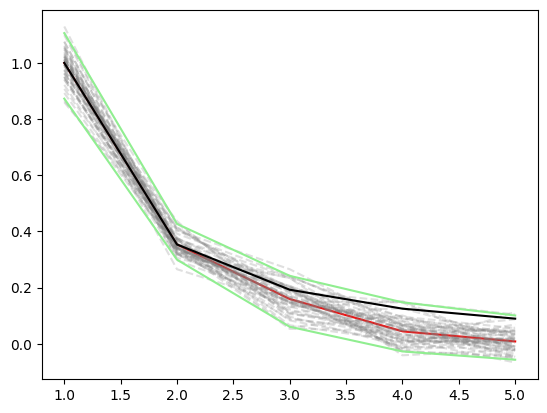

In [29]:
i_array = jnp.linspace(1, 5, 5)
ensemble = results["ensemble_history"][-1]
q = jnp.array([0.025, 0.975])
jnp.quantile(ensemble, q, axis=1)


plt.plot(i_array, jnp.mean(ensemble, axis=1), color="red")
plt.plot(i_array, ensemble, color="grey", linestyle="dashed", alpha=0.25)
plt.plot(i_array, v0, color="black")
plt.plot(i_array, jnp.quantile(ensemble, q, axis=1)[0], color="lightgreen")
plt.plot(i_array, jnp.quantile(ensemble, q, axis=1)[1], color="lightgreen")
plt.show()

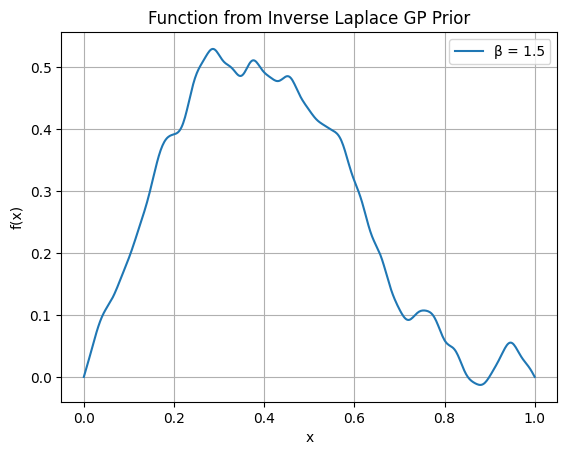

In [30]:
key = random.PRNGKey(0)
N = 50  # Number of basis functions (truncation)
M = 500  # Number of evaluation points
x = jnp.linspace(0, 1, M)  # Evaluation grid
alpha = 1.0  # Smoothness parameter

# Eigenvalues of Laplacian with Dirichlet BCs: λ_k = (kπ)^2
k_vals = jnp.arange(1, N + 1)
eigenvals = (jnp.pi * k_vals) ** 2

# Sample coefficients from GP prior: w_k ~ N(0, λ_k^{-β})
beta = 0.5 + alpha
stddev = eigenvals ** (-beta / 2)
w = random.normal(key, shape=(N,)) * stddev  # shape (N,)

# Build eigenfunctions matrix: Φ_k(x) = √2 * sin(kπx)
Phi = jnp.sqrt(2) * jnp.sin(jnp.outer(k_vals, jnp.pi * x))  # shape (N, M)

# Reconstruct the function: f(x) = ∑ w_k * Φ_k(x)
f = jnp.dot(w, Phi)  # shape (M,)

# Plotting (still using matplotlib)
plt.plot(x, f, label=f"β = {beta}")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function from Inverse Laplace GP Prior")
plt.grid(True)
plt.legend()
plt.show()

In [31]:
def get_function(w: jnp.ndarray, x: jnp.ndarray, plot=False) -> jnp.ndarray:
    """
    Reconstruct a function f(x) = ∑ w_k * φ_k(x) using Laplacian eigenfunctions on [0, 1].

    Parameters:
    ----------
    w : jnp.ndarray
        Coefficients in the Laplace eigenfunction basis (shape: [N,])
    x : jnp.ndarray
        Points at which to evaluate the function (shape: [M,], values in [0, 1])
    plot : bool
    Returns:
    -------
    f : jnp.ndarray
        The reconstructed function evaluated at points x (shape: [M,])
    plot: if True, return a plot of the reconstructed function
    """
    k_vals = jnp.arange(1, len(w) + 1)  # k = 1, ..., N
    Phi = jnp.sqrt(2) * jnp.sin(jnp.outer(k_vals, jnp.pi * x))  # shape (N, M)
    f = jnp.dot(w, Phi)  # shape (M,)

    if plot:
        plt.plot(x, f)
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title("True Function")
        plt.grid(True)
        plt.show()
    return f

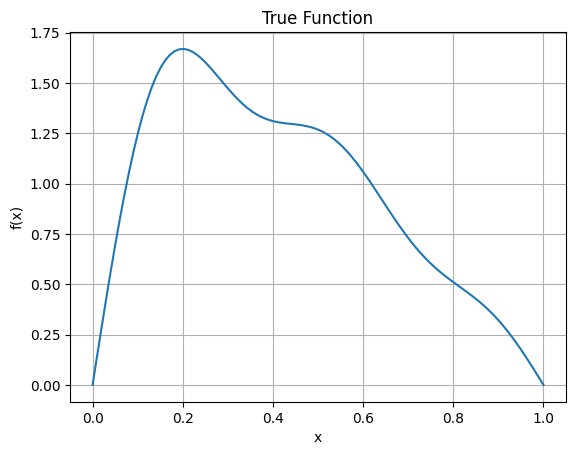

In [32]:
N = 100  # num of grid points
x = jnp.linspace(0, 1, N)
v0_func = get_function(v0, x, plot=True)

In [33]:
def solution_map(v, K, g_tilde):
    denominator = jnp.dot(K, v) + g_tilde
    return v / 2 * (denominator)

In [34]:
ensemble.shape

(5, 50)

In [35]:
def get_function(w: jnp.ndarray, x: jnp.ndarray, plot=False) -> jnp.ndarray:
    """
    Reconstruct function(s) f(x) = ∑ w_k * φ_k(x) using Laplacian eigenfunctions on [0, 1].

    Parameters:
    ----------
    w : jnp.ndarray
        Coefficients in the Laplace eigenfunction basis.
        Shape: (m,) for single particle or (m, n_particles) for ensemble.
    x : jnp.ndarray
        Points at which to evaluate the function (shape: [M,], values in [0, 1])
    plot : bool
        If True and w is a single vector, plot the reconstructed function.

    Returns:
    -------
    f : jnp.ndarray
        Reconstructed function(s) evaluated at points x.
    """

    def single_reconstruction(w_single):
        k_vals = jnp.arange(1, len(w_single) + 1)  # shape (m,)
        Phi = jnp.sqrt(2) * jnp.sin(jnp.outer(k_vals, jnp.pi * x))  # shape (m, M)
        return jnp.dot(w_single, Phi)  # shape (M,)

    if w.ndim == 1:
        f = single_reconstruction(w)  # shape (M,)
        if plot:
            plt.plot(x, f)
            plt.xlabel("x")
            plt.ylabel("f(x)")
            plt.title("Reconstructed Function")
            plt.grid(True)
            plt.show()
        return f

    else:
        # w: (m, n_particles) → transpose → (n_particles, m)
        batched_eval = vmap(single_reconstruction, in_axes=(1,), out_axes=1)
        f_all = batched_eval(w)  # shape: (n_particles, M)
        return f_all  # shape: (M, n_particles)

In [36]:
ensemble_func = get_function(ensemble, x, plot=False)

In [43]:
ensemble_func

Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 9.4916821e-02,  9.9416114e-02,  1.0260094e-01, ...,
         9.7691603e-02,  1.2284188e-01,  1.0003907e-01],
       [ 1.8956174e-01,  1.9862448e-01,  2.0475924e-01, ...,
         1.9496056e-01,  2.4469145e-01,  1.9970757e-01],
       ...,
       [ 3.3217721e-02,  2.3971392e-02,  9.6954048e-02, ...,
         3.8471520e-02,  1.3878404e-01,  4.8030797e-02],
       [ 1.6488155e-02,  1.1831404e-02,  4.8631705e-02, ...,
         1.9216949e-02,  6.9812424e-02,  2.3978209e-02],
       [ 1.4302314e-08,  5.0421026e-08, -8.5286501e-08, ...,
        -1.7191361e-08, -1.6543734e-07, -1.2567345e-08]], dtype=float32)

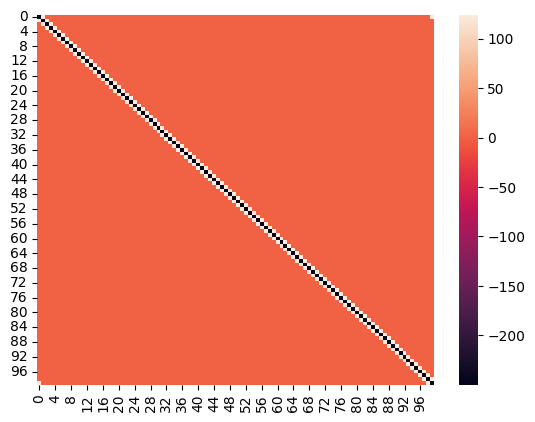

In [50]:
def solution_map(v: jnp.ndarray, K: jnp.ndarray, g_tilde: jnp.ndarray) -> jnp.ndarray:
    """ """

    def solution_map_single(v, K, g_tilde):
        denominator = jnp.dot(K, v) + g_tilde
        return v / 2 * (denominator)

    if v.ndim == 1:
        f = solution_map_single(v, K, g_tilde)  # shape (M,)
        return f

    else:
        # w: (m, n_particles) → transpose → (n_particles, m)
        batched_eval = vmap(solution_map_single, in_axes=(1, None, None), out_axes=1)
        f_all = batched_eval(v, K, g_tilde)  # shape: (n_particles, M)
        return f_all  # shape: (M, n_particles)


D = N - 1
L = 2 * jnp.pi
x_indices = jnp.arange(D + 1)
x_array = (2 * jnp.pi * x_indices) / (D + 1)
f_array = jnp.exp(0.5 * jnp.sin(x_array))
plot = True
fourier = False
model = Schroedinger(D, D, f_array, plot, fourier)
laplace = model.operator

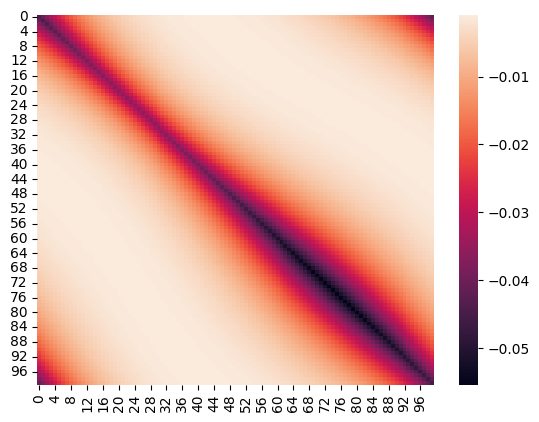

In [39]:
sns.heatmap(jnp.linalg.pinv(laplace))
plt.show()

In [40]:
g_array = jnp.ones(N) + x_array
g_array.shape

(100,)

In [41]:
K = jnp.linalg.pinv(laplace)
# Create g_array (right-hand side)
g_tilde = jnp.ones(N) + x_array

f0_func = solution_map(ensemble_func, K, g_tilde)

In [52]:
f0 = solution_map(v0_func, K, g_tilde)

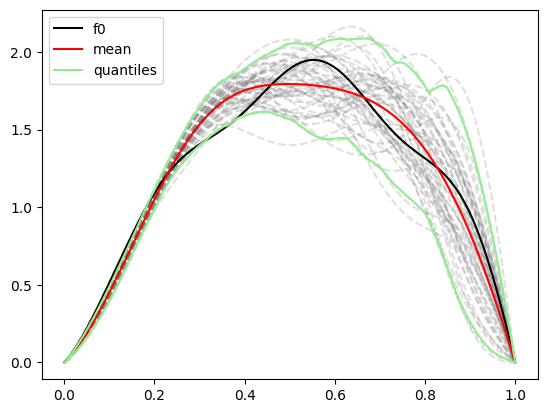

In [62]:
q = jnp.array([0.025, 0.975])


plt.plot(x, f0_func, color="grey", linestyle="dashed", alpha=0.25)
plt.plot(x, f0, color="black", label="f0")
plt.plot(x, jnp.mean(f0_func, axis=1), color="red", label="mean")
plt.plot(x, jnp.quantile(f0_func, q, axis=1)[0], color="lightgreen", label="quantiles")
plt.plot(x, jnp.quantile(f0_func, q, axis=1)[1], color="lightgreen")
plt.legend()
plt.show()